<a href="https://colab.research.google.com/github/DiegoMartin-prog/Thesis-Project/blob/main/Benchmark%20Implementations/NLMeans_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/MMMIP/assignment_14

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/MMMIP/assignment_14


In [ ]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
import math


In [ ]:
rootfolder = 'data'

Load the image and rescale it in $[0,1]$

In [ ]:
img = imread(f'{rootfolder}/cameraman.png') / 255
#img = img[100:180, 100:180]

imsz = img.shape

# patch size
p = 7

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 11


Corrupt the image with white gaussian noise

In [ ]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [ ]:
mse = 1/imsz[0]**2 * np.sum((img - noisy_img)**2)
psnr_noisy = 10 * math.log10(1/mse)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.10')

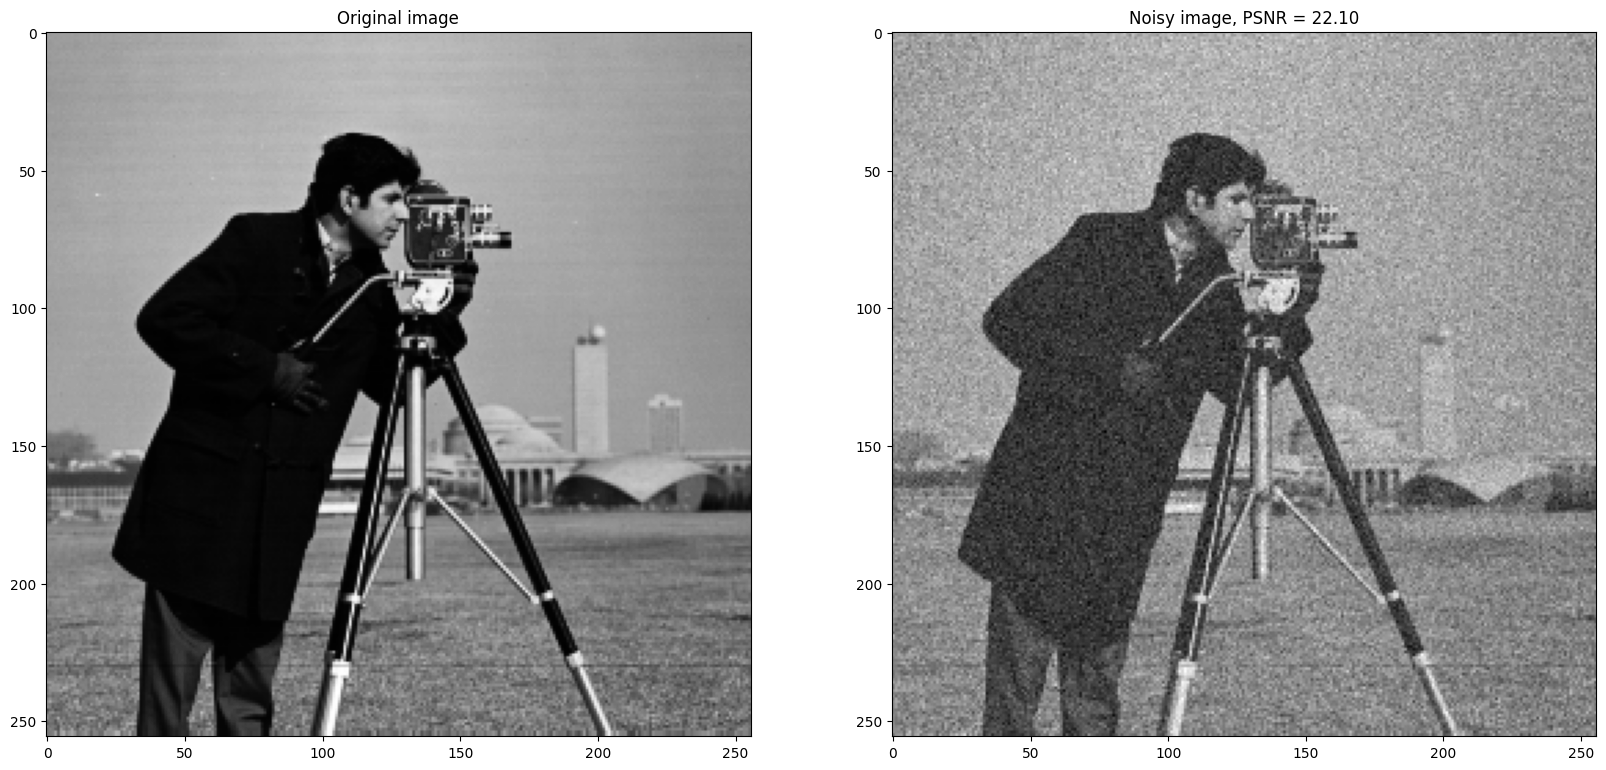

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [ ]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, H, mode='symmetric')


Main loop

In [ ]:
# Save patch offset
po = int(p/2)

for i in range(0, imsz[0]):
    for j in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        i_pad = i+H
        j_pad = j+H
        s = img_pad[i_pad-po:i_pad+po+1, j_pad-po:j_pad+po+1]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for r in range(-H, H):
            for c in range(-H, H):
                # extract the patch in the neighborhood of the selected patch s
                i_prime = r + i_pad
                j_prime = c + j_pad
                if (i_prime >= p and i_prime <= imsz[0]+p-1 and j_prime >= p and j_prime <= imsz[1]+p-1):
                  z = img_pad[i_prime-po:i_prime+po+1, j_prime-po:j_prime+po+1]
                  #print(s.shape, z.shape)
                  # compute the distance with the reference patch
                  d = np.linalg.norm(s - z, 2)

                  # update the weight and the pixel estimate
                  w = np.exp(-d**2/(sigma_noise**2*M))
                  pixel_hat += w * img_pad[i_prime, j_prime]
                  weight += w

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat/weight


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.30')

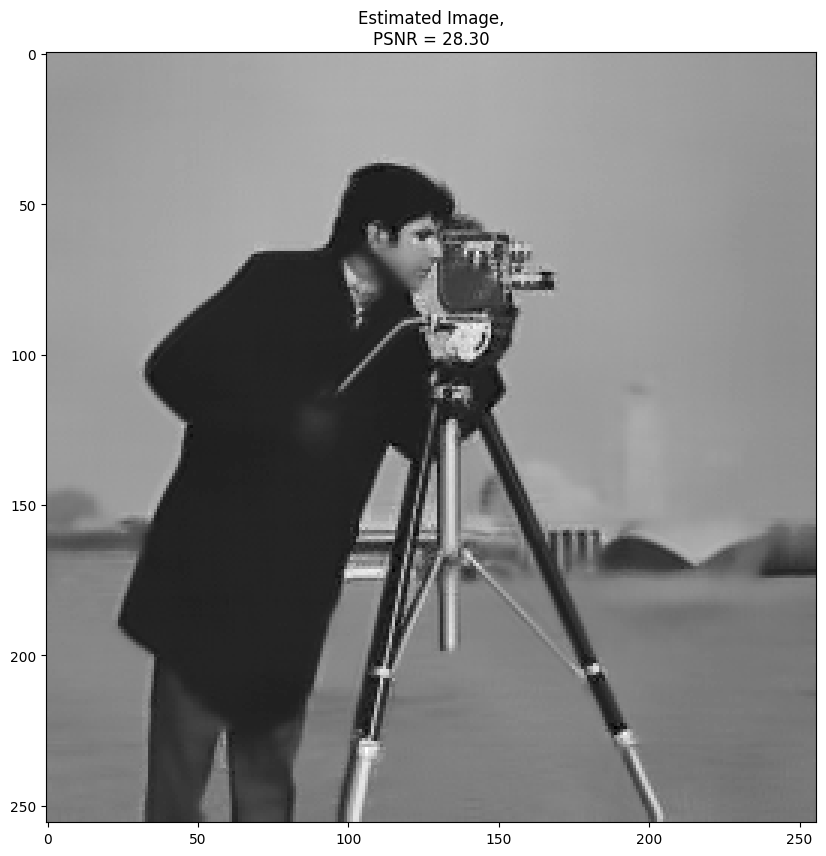

In [ ]:
mse_hat = 1/imsz[0]**2 * np.sum((img - img_hat)**2)
psnr_hat = 10 * math.log10(1/mse_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')


Let's try using the skimage.restoration package

Link to the function's doc: https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_nl_means

In [ ]:
from skimage.restoration import denoise_nl_means
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio

In [ ]:
new_img = img_as_float(noisy_img)

Text(0.5, 1.0, 'New image, PSNR = 22.10')

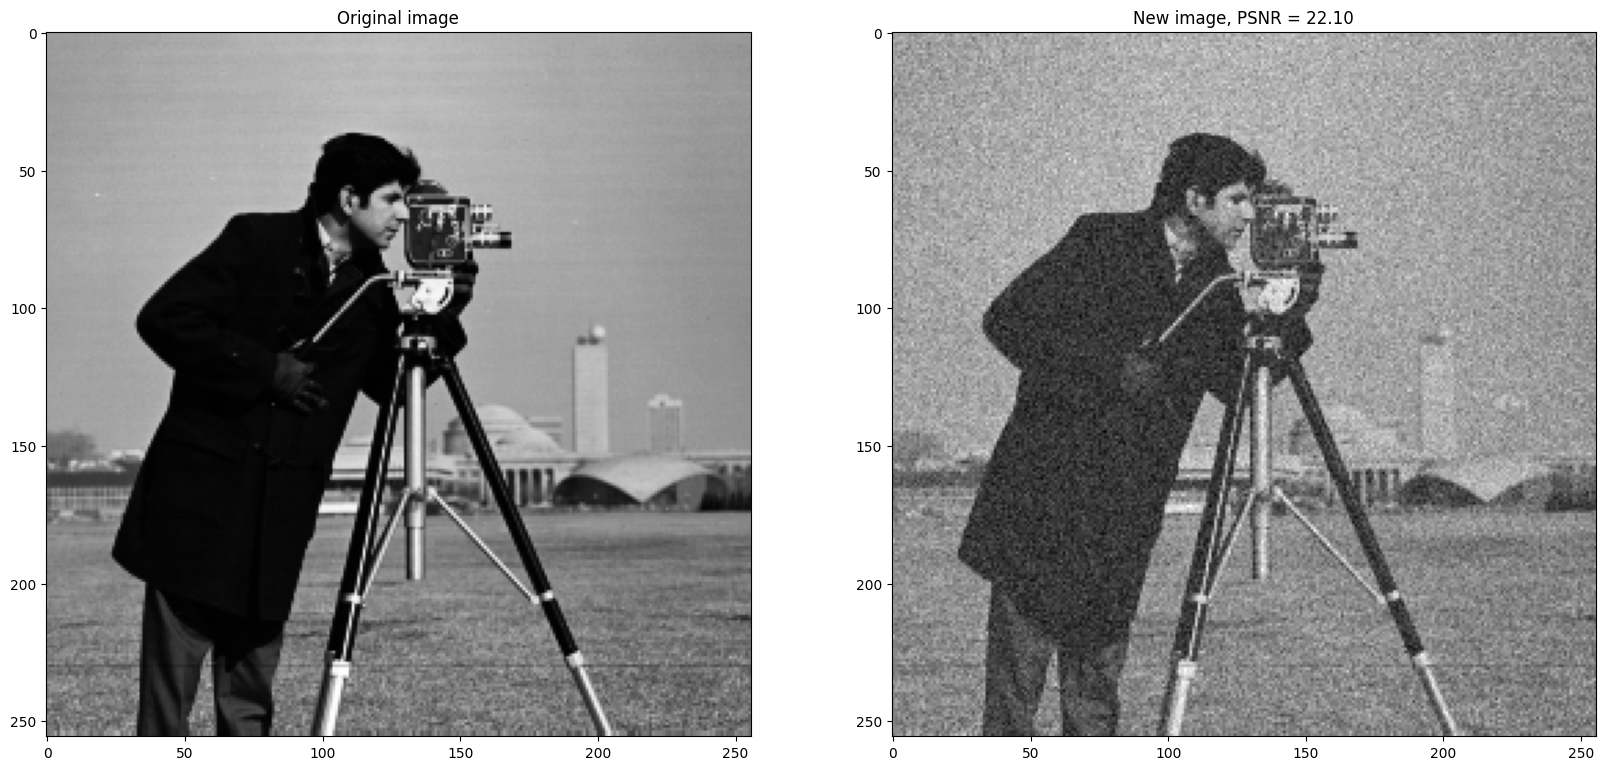

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(new_img, cmap='gray')
ax[1].set_title(f'New image, PSNR = {psnr_noisy:.2f}')

Setting proper parameters

In [ ]:
# Variable used to enable or disable fast mode
fast_mode = False

# Variable used to decide the degree of similarity of neighboring patches
# Given sigma is provided. If fast mode is on: h = 0.8 * sigma, else: h = 0.6 * sigma
h = 0.6 * sigma_noise

# patch_size
ps = p

# patch_distance (radius of neighborhood)
pd = H

In [ ]:
denoised_img = denoise_nl_means(new_img, ps, pd, h, fast_mode=fast_mode, sigma=sigma_noise)

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.86')

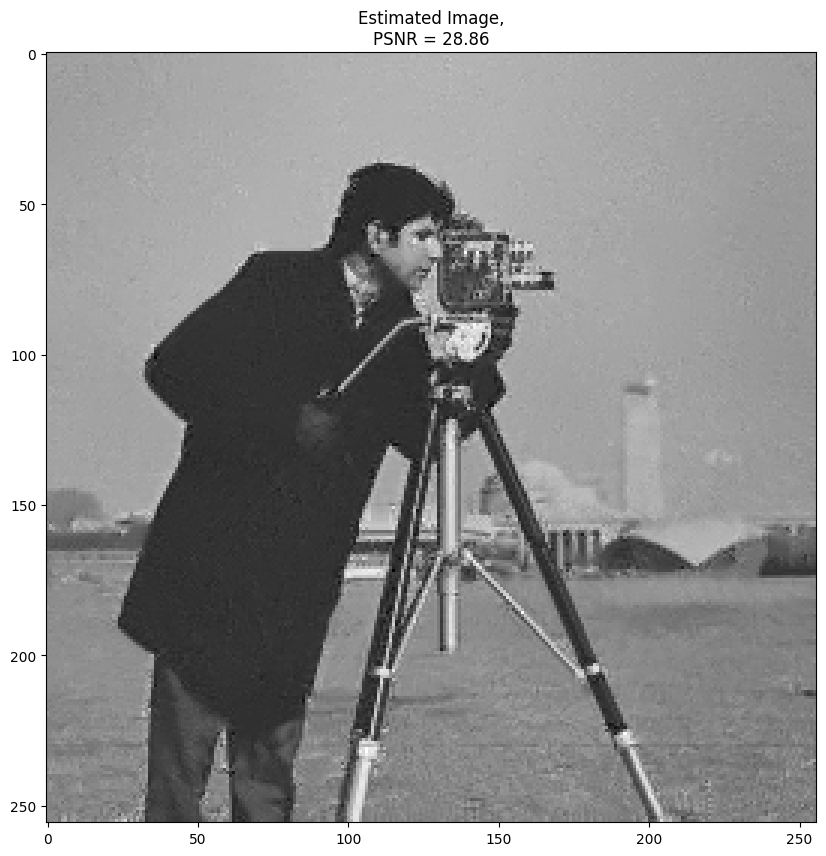

In [ ]:
#psnr_new = peak_signal_noise_ratio(new_img, denoised_img)
mse_new = 1/imsz[0]**2 * np.sum((img - denoised_img)**2)
psnr_new = 10 * math.log10(1/mse_new)
plt.figure(figsize=(10,10))
plt.imshow(denoised_img, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_new:.2f}')